In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import subplots
from statsmodels.api import OLS, add_constant
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path

### Problem 8:

(a) Generate random numbers for X and e

(b) Generate response as polynomial degree 3 of X

(c) Using C_p forward selection, only X_2 is selected

In [94]:
np.random.seed(100)
X = np.random.normal(loc=0, scale=10, size=100)

np.random.seed(101)
e = np.random.normal(loc=0, scale=10, size=100)

print(X[:5])
print(e[:5])

beta_0, beta_1, beta_2, beta_3 = 1, 1, 1, 1
y = [beta_0 + beta_1 * (X[i] ** 1) + beta_2 * (X[i] ** 2) + beta_3 * (X[i] ** 3) + e[i] for i in range(len(X))]

print(y[:5])


[-17.49765473   3.42680403  11.53035803  -2.52436037   9.81320787]
[27.06849839  6.28132709  9.07969446  5.03825754  6.51117948]
[-5040.481807709409, 62.692028388329256, 1687.5105788746287, -6.1999295828459005, 1058.6260184729974]


<Axes: >

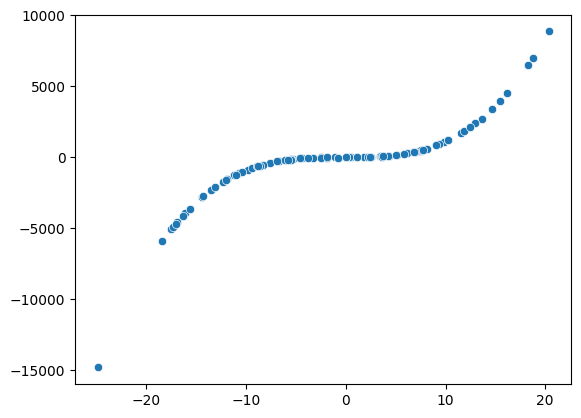

In [95]:
sns.scatterplot(x=X, y=y)

In [96]:
df = pd.DataFrame({'X': X})
for i in range(2, 11):
    df[f'X_{i}'] = df['X'] ** i

df = add_constant(df)
df.head()

,const,X,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,1.0,-17.497655,306.167921,-5357.220572,93738.795892,-1.640209e+06,2.869981e+07,-5.021794e+08,8.786962e+09,-1.537512e+11,2.690286e+12
1,1.0,3.426804,11.742986,40.240911,137.897717,4.725485e+02,1.619331e+03,5.549130e+03,1.901578e+04,6.516335e+04,2.233020e+05
2,1.0,11.530358,132.949156,1532.951370,17675.478134,2.038046e+05,2.349940e+06,2.709565e+07,3.124225e+08,3.602344e+09,4.153631e+10
3,1.0,-2.524360,6.372395,-16.086222,40.607421,-1.025078e+02,2.587665e+02,-6.532200e+02,1.648963e+03,-4.162576e+03,1.050784e+04
4,1.0,9.813208,96.299049,945.002582,9273.506779,9.100285e+04,8.930299e+05,8.763488e+06,8.599793e+07,8.439155e+08,8.281519e+09


In [97]:
model = OLS(y, df)
result = model.fit()
ols = result.predict(df)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.296e+05
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          3.14e-211
Time:                        13:59:17   Log-Likelihood:                -370.08
No. Observations:                 100   AIC:                             762.2
Df Residuals:                      89   BIC:                             790.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0406      2.323      0.448      0.655      -3.576       5.657
X              1.2579      0.726      1.734      0.086      -0.184       2.699
X_2            0.9378      0.167      5.608      0.000       0.605       1.270
X_3            0.9924      0.021     47.252      0.000       0.951       1.034
X_4            0.0015      0.003      0.476      0.635      -0.005       0.008
X_5         8.106e-05      0.000      0.437      0.663      -0.000       0.000
X_6        -6.806e-06   2.07e-05     -0.329      0.743   -4.79e-05    3.43e-05
X_7        -3.203e-07   6.21e-07     -0.516      0.607   -1.55e-06    9.13e-07
X_8         9.868e-09   5.67e-08      0.174      0.862   -1.03e-07    1.23e-07
X_9         3.965e-10   6.98e-10      0.568      0.571    -9.9e-10    1.78e-09
X_10       -1.624e-12   5.33e-11     -0.030      0.976   -1.07e-10    1.04e-10
==============================================================================
Omnibus:                        1.238   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                1.275
Skew:                           0.188   Prob(JB):                        0.529
Kurtosis:                       2.594   Cond. No.                     2.06e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
def nCp(sigma2, estimator, X, y):
    n, p = X.shape
    yhat = estimator.predict(X)
    RSS = np.sum((y - yhat) ** 2)
    return - (RSS + 2 * p * sigma2) / n

sigma2 = result.scale
neg_Cp = partial(nCp, sigma2)

def forward_selection(X, y, sigma2):
    remaining_features = list(X.columns)
    selected_features = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining_features and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining_features:
            model = OLS(y, add_constant(pd.DataFrame(X[selected_features + [candidate]]))).fit()
            score = neg_Cp(model, add_constant(pd.DataFrame(X[selected_features + [candidate]])), y)
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if current_score > best_new_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
    print(selected_features)
    model = OLS(y, add_constant(pd.DataFrame(X[selected_features]))).fit()
    return model

model = forward_selection(df, y, sigma2)
print(model.summary())


['const']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 28 Jul 2024   Prob (F-statistic):                nan
Time:                        13:59:26   Log-Likelihood:                -928.42
No. Observations:                 100   AIC:                             1859.
Df Residuals:                      99   BIC:                             1861.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -214.4804    261.821     -0.81

In [99]:
lasso_cv = skl.LassoCV(cv=5, random_state=42)
lasso_cv.fit(df, y)

best_lambda = lasso_cv.alpha_
print(f"Best lambda (alpha) from cross-validation: {best_lambda}")
print(f"R-squared score on the test set: {lasso_cv.score(df, y)}")

lasso_coefficients = lasso_cv.coef_
print(f"Lasso coefficients: {lasso_coefficients}")

Best lambda (alpha) from cross-validation: 85694619461278.89
R-squared score on the test set: 0.6067307411031959
Lasso coefficients: [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  7.76704302e-09  1.50707016e-10]


<Axes: >

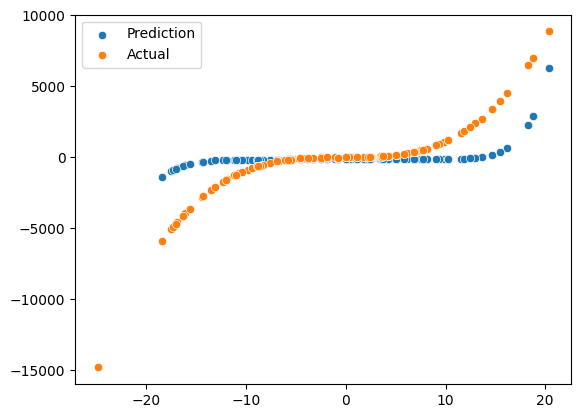

In [100]:
pred = lasso_cv.predict(df)
sns.scatterplot(x=X, y=pred, label='Prediction')
sns.scatterplot(x=X, y=y, label='Actual')

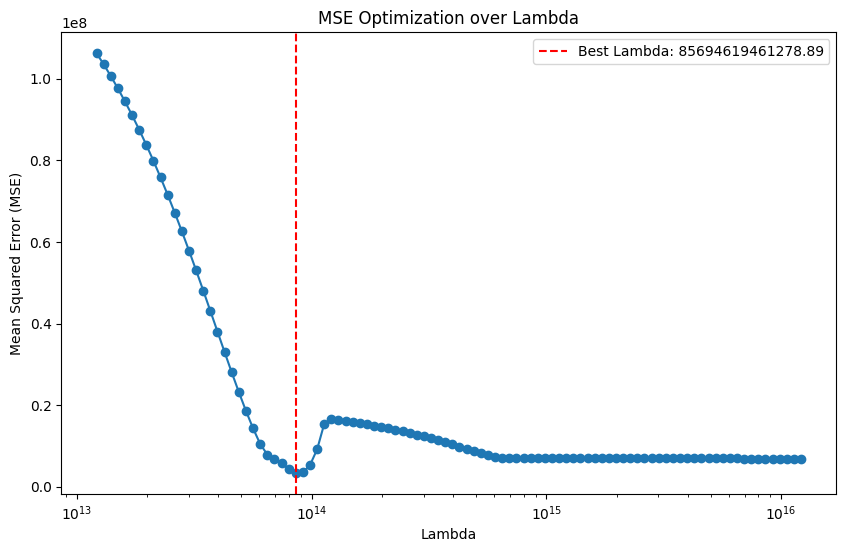

In [101]:
mse_path = lasso_cv.mse_path_
mean_mse = mse_path.mean(axis=1)
lambdas = lasso_cv.alphas_

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mean_mse, marker='o')
plt.axvline(best_lambda, linestyle='--', color='r', label=f'Best Lambda: {best_lambda}')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Optimization over Lambda')
plt.legend()
plt.show()